# Preprocessing

## Bronze (NOAA raw)

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[4]") \
    .appName("AIS") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark OK")


Spark OK


## Silver Layer

In [3]:
import duckdb
import os

# ==============================
# 1. Kết nối DuckDB (local)
# ==============================

conn = duckdb.connect()

# ==============================
# 2. Đường dẫn file AIS gốc
# ==============================

file_path = "C:/folder_paquet/2023_NOAA_AIS_logs_04.parquet"


output_path = "C:/folder_paquet/cali_apr2023_350ships_clean"

# Tạo thư mục nếu chưa có
os.makedirs(output_path, exist_ok=True)

# ==============================
# 3. Lọc dữ liệu cơ bản
# ==============================

base_query = f"""
SELECT *
FROM '{file_path}'
WHERE BaseDateTime >= '2023-04-01'
  AND BaseDateTime <  '2023-05-01'
  AND LAT BETWEEN 33.2 AND 34.1
  AND LON BETWEEN -119.1 AND -117.9
  AND SOG > 3
  AND COG >= 0 AND COG < 360
  AND Heading >= 0 AND Heading < 360
"""

print("Filtering base dataset...")

# ==============================
# 4. Chọn top 350 MMSI
# ==============================

top_mmsi = conn.execute(f"""
SELECT MMSI, COUNT(*) AS n_points
FROM ({base_query})
GROUP BY MMSI
ORDER BY n_points DESC
LIMIT 350
""").df()

print(f"Selected {len(top_mmsi)} MMSI")

# ==============================
# 5. Tạo danh sách MMSI
# ==============================

mmsi_list = ", ".join(str(m) for m in top_mmsi["MMSI"])

subset_query = f"""
SELECT * FROM ({base_query})
WHERE MMSI IN ({mmsi_list})
"""

base_stats = conn.execute(f"""
SELECT 
    COUNT(*) AS total,
    COUNT(DISTINCT MMSI) AS ships
FROM ({base_query})
""").df()

print("Base filtering stats:")
print(base_stats)


subset_stats = conn.execute(f"""
SELECT COUNT(*) AS total
FROM ({subset_query})
""").df()

print("Top 350 subset stats:")
print(subset_stats)




# ==============================
# 6. Xuất ra Parquet partition
# ==============================

# print("Writing partitioned parquet...")

# conn.execute(f"""
# COPY (
#   SELECT *, MMSI AS MMSI_copy
#   FROM ({subset_query})
# )
# TO '{output_path}'
# (FORMAT PARQUET, COMPRESSION 'zstd', PARTITION_BY (MMSI));
# """)

print("Done!")



Filtering base dataset...
Selected 350 MMSI
Base filtering stats:
    total  ships
0  424780    693
Top 350 subset stats:
    total
0  366078
Done!


In [4]:
count_base = conn.execute(f"""
SELECT COUNT(*) 
FROM ({base_query})
""").fetchone()[0]

print("Total valid AIS points after base filtering:", count_base)

count_subset = conn.execute(f"""
SELECT COUNT(*)
FROM ({subset_query})
""").fetchone()[0]

print("Total AIS points for top 350 ships:", count_subset)


Total valid AIS points after base filtering: 424780
Total AIS points for top 350 ships: 366078


## Feature Data

In [5]:
import pandas as pd
import glob
import os

base_path = "C:/folder_paquet/cali_apr2023_350ships_clean"

all_files = glob.glob(os.path.join(base_path, "MMSI=*/data_*.parquet"))

print(f"Found {len(all_files)} parquet files")

dfs = [pd.read_parquet(f) for f in all_files]

df = pd.concat(dfs, ignore_index=True)

print("Total rows:", len(df))

dfs = [pd.read_parquet(f) for f in all_files] # dùng vòng lặp đọc từng file một.
df_all = pd.concat(dfs, ignore_index=True) # gộp theo chiều dọc tạo dataframe duy nhất.

Found 1133 parquet files
Total rows: 366078


----

----

In [6]:
print(df.columns)



Index(['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'MMSI_copy'], dtype='object')


In [7]:
df = df.rename(columns={"MMSI_copy": "MMSI"})

df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])
df = df.sort_values(["MMSI", "BaseDateTime"])


In [8]:
df["delta_t"] = (
    df.groupby("MMSI")["BaseDateTime"]
      .diff()
      .dt.total_seconds()
)

# Lọc thời gian bất thường
df = df[(df["delta_t"] > 1) & (df["delta_t"] <= 300)]

print("After delta_t filtering:", len(df))


After delta_t filtering: 352124


In [9]:
import numpy as np

df["Heading_sin"] = np.sin(np.deg2rad(df["Heading"]))
df["Heading_cos"] = np.cos(np.deg2rad(df["Heading"]))

df["COG_sin"] = np.sin(np.deg2rad(df["COG"]))
df["COG_cos"] = np.cos(np.deg2rad(df["COG"]))


In [10]:
df["hour"] = df["BaseDateTime"].dt.hour

df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)


In [11]:
R = 6371000

df["X_m"] = np.deg2rad(df["LON"]) * R
df["Y_m"] = np.deg2rad(df["LAT"]) * R


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[["X_norm", "Y_norm"]] = scaler.fit_transform(df[["X_m", "Y_m"]])


In [13]:
df_cleaned = df.copy()
print(df.columns)


df.head()






Index(['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'MMSI',
       'delta_t', 'Heading_sin', 'Heading_cos', 'COG_sin', 'COG_cos', 'hour',
       'hour_sin', 'hour_cos', 'X_m', 'Y_m', 'X_norm', 'Y_norm'],
      dtype='object')


,BaseDateTime,LAT,LON,SOG,COG,Heading,MMSI,delta_t,Heading_sin,Heading_cos,COG_sin,COG_cos,hour,hour_sin,hour_cos,X_m,Y_m,X_norm,Y_norm
629,2023-04-04 16:26:55,33.93878,-119.09661,10.2,126.7,131.0,209795000,70.0,0.754710,-0.656059,0.801776,-0.597625,16,-0.866025,-0.5,-1.324294e+07,3.773820e+06,-2.795538,1.731242
630,2023-04-04 16:28:05,33.93667,-119.09357,10.1,131.7,135.0,209795000,70.0,0.707107,-0.707107,0.746638,-0.665230,16,-0.866025,-0.5,-1.324260e+07,3.773586e+06,-2.784095,1.717233
631,2023-04-04 16:29:14,33.93444,-119.09071,10.2,132.7,135.0,209795000,69.0,0.707107,-0.707107,0.734915,-0.678160,16,-0.866025,-0.5,-1.324228e+07,3.773338e+06,-2.773328,1.702428
632,2023-04-04 16:30:25,33.93211,-119.08772,10.2,132.3,135.0,209795000,71.0,0.707107,-0.707107,0.739631,-0.673013,16,-0.866025,-0.5,-1.324195e+07,3.773078e+06,-2.762073,1.686958
633,2023-04-04 16:31:35,33.92991,-119.08484,10.1,131.7,134.0,209795000,70.0,0.719340,-0.694658,0.746638,-0.665230,16,-0.866025,-0.5,-1.324163e+07,3.772834e+06,-2.751231,1.672351


## Sliding Window (t0..t9 → t10)

In [14]:
df = df.sort_values(["MMSI", "BaseDateTime"])


In [15]:
df = df[(df["SOG"] >= 6) & (df["SOG"] <= 40)]


In [16]:
FEATURE_INPUT = [
    "SOG",
    "Heading_sin", "Heading_cos",
    "COG_sin", "COG_cos",
    "X_norm", "Y_norm",
    "hour_sin", "hour_cos"
]

TARGET = ["X_norm", "Y_norm"]

df = df.sort_values(["MMSI", "BaseDateTime"])



In [17]:
window_size = 10
rows = []

for mmsi, group in df.groupby("MMSI"):
    group = group.reset_index(drop=True)

    for i in range(len(group) - window_size):
        window = group.loc[i:i+window_size-1, FEATURE_INPUT].values
        target = group.loc[i+window_size, ['X_norm','Y_norm']].values
        
        row = window.flatten().tolist() + target.tolist()
        rows.append(row)

columns = []
for t in range(window_size):
    for f in FEATURE_INPUT:
        columns.append(f"{f}_t{t}")

columns += ['target_X','target_Y']

df_train = pd.DataFrame(rows, columns=columns)

print("Shape after window:", df_train.shape)


Shape after window: (278366, 92)


In [18]:
df_train.columns.tolist()
df_train.head()
print(df_train.columns)

Index(['SOG_t0', 'Heading_sin_t0', 'Heading_cos_t0', 'COG_sin_t0',
       'COG_cos_t0', 'X_norm_t0', 'Y_norm_t0', 'hour_sin_t0', 'hour_cos_t0',
       'SOG_t1', 'Heading_sin_t1', 'Heading_cos_t1', 'COG_sin_t1',
       'COG_cos_t1', 'X_norm_t1', 'Y_norm_t1', 'hour_sin_t1', 'hour_cos_t1',
       'SOG_t2', 'Heading_sin_t2', 'Heading_cos_t2', 'COG_sin_t2',
       'COG_cos_t2', 'X_norm_t2', 'Y_norm_t2', 'hour_sin_t2', 'hour_cos_t2',
       'SOG_t3', 'Heading_sin_t3', 'Heading_cos_t3', 'COG_sin_t3',
       'COG_cos_t3', 'X_norm_t3', 'Y_norm_t3', 'hour_sin_t3', 'hour_cos_t3',
       'SOG_t4', 'Heading_sin_t4', 'Heading_cos_t4', 'COG_sin_t4',
       'COG_cos_t4', 'X_norm_t4', 'Y_norm_t4', 'hour_sin_t4', 'hour_cos_t4',
       'SOG_t5', 'Heading_sin_t5', 'Heading_cos_t5', 'COG_sin_t5',
       'COG_cos_t5', 'X_norm_t5', 'Y_norm_t5', 'hour_sin_t5', 'hour_cos_t5',
       'SOG_t6', 'Heading_sin_t6', 'Heading_cos_t6', 'COG_sin_t6',
       'COG_cos_t6', 'X_norm_t6', 'Y_norm_t6', 'hour_sin_t6', 'hour_c

In [19]:
import utils_1

df_all_proc, meta =  utils_1.build_phase_features(df_all) # dùng hàm ở module utils_1.py để tạo các đặc trưng cần thiết. lưu độ lệch chuẩn đã chuẩn hóa vào meta.

shards = utils_1.build_sequence_samples_limited(
    df_all_proc,
    feature_cols=FEATURE_INPUT,
    seq_len=10,
    stop_speed=6.0,
    max_time_gap=300.0,
    max_sog=40.0,
    mmsi_col="MMSI_copy",
    time_col="BaseDateTime",
    target_cols=tuple(TARGET),
    stride=1,
    max_samples_per_group=270_000,
    max_total_groups=10
)


# Ghép thành 1 DataFrame lớn (nếu đủ RAM)
df_train = pd.concat(shards, ignore_index=True)

In [20]:
print(list(df_train.columns)) # kiểm tra 
df_train.head()

['SOG_t0', 'Heading_sin_t0', 'Heading_cos_t0', 'COG_sin_t0', 'COG_cos_t0', 'X_norm_t0', 'Y_norm_t0', 'hour_sin_t0', 'hour_cos_t0', 'SOG_t1', 'Heading_sin_t1', 'Heading_cos_t1', 'COG_sin_t1', 'COG_cos_t1', 'X_norm_t1', 'Y_norm_t1', 'hour_sin_t1', 'hour_cos_t1', 'SOG_t2', 'Heading_sin_t2', 'Heading_cos_t2', 'COG_sin_t2', 'COG_cos_t2', 'X_norm_t2', 'Y_norm_t2', 'hour_sin_t2', 'hour_cos_t2', 'SOG_t3', 'Heading_sin_t3', 'Heading_cos_t3', 'COG_sin_t3', 'COG_cos_t3', 'X_norm_t3', 'Y_norm_t3', 'hour_sin_t3', 'hour_cos_t3', 'SOG_t4', 'Heading_sin_t4', 'Heading_cos_t4', 'COG_sin_t4', 'COG_cos_t4', 'X_norm_t4', 'Y_norm_t4', 'hour_sin_t4', 'hour_cos_t4', 'SOG_t5', 'Heading_sin_t5', 'Heading_cos_t5', 'COG_sin_t5', 'COG_cos_t5', 'X_norm_t5', 'Y_norm_t5', 'hour_sin_t5', 'hour_cos_t5', 'SOG_t6', 'Heading_sin_t6', 'Heading_cos_t6', 'COG_sin_t6', 'COG_cos_t6', 'X_norm_t6', 'Y_norm_t6', 'hour_sin_t6', 'hour_cos_t6', 'SOG_t7', 'Heading_sin_t7', 'Heading_cos_t7', 'COG_sin_t7', 'COG_cos_t7', 'X_norm_t7', 'Y

,SOG_t0,Heading_sin_t0,Heading_cos_t0,COG_sin_t0,COG_cos_t0,X_norm_t0,Y_norm_t0,hour_sin_t0,hour_cos_t0,SOG_t1,...,Heading_sin_t9,Heading_cos_t9,COG_sin_t9,COG_cos_t9,X_norm_t9,Y_norm_t9,hour_sin_t9,hour_cos_t9,X_norm,Y_norm
0,10.1,0.798635,-0.601815,0.830012,-0.557745,-2.829472,1.739799,-0.916625,-0.399749,10.2,...,0.707107,-0.707107,0.730162,-0.683274,-2.726229,1.606196,-0.934230,-0.356670,-2.713598,1.589180
1,10.2,0.754710,-0.656059,0.801776,-0.597625,-2.816954,1.727037,-0.918648,-0.395078,10.1,...,0.707107,-0.707107,0.724172,-0.689620,-2.713598,1.589180,-0.936264,-0.351297,-2.702366,1.574024
2,10.1,0.707107,-0.707107,0.746638,-0.665230,-2.805458,1.713012,-0.920647,-0.390396,10.2,...,0.707107,-0.707107,0.732543,-0.680721,-2.702366,1.574024,-0.938040,-0.346526,-2.691210,1.559002
3,10.2,0.707107,-0.707107,0.734915,-0.678160,-2.794642,1.698190,-0.922594,-0.385772,10.2,...,0.707107,-0.707107,0.734915,-0.678160,-2.691210,1.559002,-0.939792,-0.341747,-2.678503,1.542053
4,10.2,0.707107,-0.707107,0.739631,-0.673012,-2.783334,1.682702,-0.924574,-0.381003,10.1,...,0.731354,-0.681998,0.743145,-0.669131,-2.678503,1.542053,-0.941740,-0.336342,-2.668746,1.529623


In [21]:
df_train.shape


(212934, 92)

In [22]:
print("Rows before window:", len(df))
print(df.head())


Rows before window: 281860
           BaseDateTime       LAT        LON   SOG    COG  Heading       MMSI  \
629 2023-04-04 16:26:55  33.93878 -119.09661  10.2  126.7    131.0  209795000   
630 2023-04-04 16:28:05  33.93667 -119.09357  10.1  131.7    135.0  209795000   
631 2023-04-04 16:29:14  33.93444 -119.09071  10.2  132.7    135.0  209795000   
632 2023-04-04 16:30:25  33.93211 -119.08772  10.2  132.3    135.0  209795000   
633 2023-04-04 16:31:35  33.92991 -119.08484  10.1  131.7    134.0  209795000   

     delta_t  Heading_sin  Heading_cos   COG_sin   COG_cos  hour  hour_sin  \
629     70.0     0.754710    -0.656059  0.801776 -0.597625    16 -0.866025   
630     70.0     0.707107    -0.707107  0.746638 -0.665230    16 -0.866025   
631     69.0     0.707107    -0.707107  0.734915 -0.678160    16 -0.866025   
632     71.0     0.707107    -0.707107  0.739631 -0.673013    16 -0.866025   
633     70.0     0.719340    -0.694658  0.746638 -0.665230    16 -0.866025   

     hour_cos    

In [23]:
print("Unique ships:", df["MMSI"].nunique())
print(df.groupby("MMSI").size().describe())


Unique ships: 350
count      350.000000
mean       805.314286
std       1132.727010
min          4.000000
25%        392.000000
50%        499.000000
75%        670.250000
max      11591.000000
dtype: float64


In [24]:
# lưu tập data

df_train.to_csv("train_dataset.csv", index=False)


In [25]:
from sqlalchemy import create_engine

server = "localhost"
port = 1433
database = "Data_2023"
username = "sa"
password = "123Strong!"  # thay password của bạn

connection_string = (
    f"mssql+pyodbc://{username}:{password}@{server}:{port}/{database}"
    "?driver=ODBC+Driver+18+for+SQL+Server"
    "&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

with engine.connect() as conn:
    print("Connected OK")


Connected OK


In [26]:
safe_chunksize = max(10, 2000 // len(df_train.columns))

df_train.to_sql(
    name="NOAA_AIS",
    con=engine,
    if_exists="replace",
    index=False,
    chunksize=safe_chunksize,
    method="multi"
)


212934

In [27]:
engine = create_engine(connection_string)

df = pd.read_sql("SELECT * FROM NOAA_AIS", engine)

print(df.shape)
df_train = df

(212934, 92)


# HISTOGRAM

In [28]:
# Helper vẽ histogram cho nhiều cột
import matplotlib.pyplot as plt


def plot_hist_stage(df, cols, title_prefix, bins=100, xlim=None, sample_max=200_000, logy=False):
    """Vẽ histogram cho một list cột trong cùng 1 figure.

    - df: DataFrame
    - cols: list tên cột
    - title_prefix: 'RAW', 'CLEANED', 'SCALED', ...
    - sample_max: nếu số dòng quá lớn sẽ sample để vẽ nhanh
    """
    if isinstance(cols, str):
        cols = [cols]

    if df is None or len(df) == 0:
        print(f"[{title_prefix}] DataFrame rỗng, không có gì để vẽ.")
        return

    if len(df) > sample_max:
        df_plot = df.sample(n=sample_max, random_state=42)
    else:
        df_plot = df

    n = len(cols)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, cols):
        if col not in df_plot.columns:
            ax.set_title(f"{title_prefix} – {col} (missing)")
            ax.axis("off")
            continue

        data = df_plot[col].dropna().to_numpy()
        ax.hist(data, bins=bins, color="steelblue", alpha=0.8)
        ax.set_title(f"{title_prefix} – {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

        if xlim is not None and col in xlim:
            ax.set_xlim(xlim[col])
        if logy:
            ax.set_yscale("log")

    plt.tight_layout()
    plt.show()

In [38]:
print("RAW rows:", len(df_all))
print("CLEAN rows:", len(df_cleaned))

RAW rows: 366078
CLEAN rows: 352124


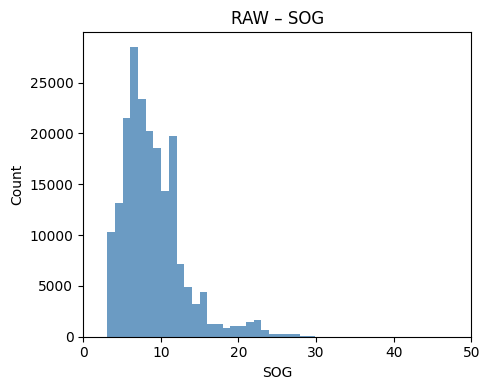

In [ ]:
# 1 Histogram RAW DATA – hiểu phân phối gốc
# RAW: dùng df_all sau khi concat toàn bộ parquet (sau DuckDB lọc cơ bản).

RAW_COLS = ["SOG"]  # có thể thêm 'COG', 'Heading' nếu muốn

plot_hist_stage(
    df=df_all,
    cols=RAW_COLS,
    title_prefix="RAW",
    bins=100,
    xlim={"SOG": (0, 50)},
    logy=False,
)

CLEANED shape: (280459, 19)
SOG range: 6.0 → 25.0


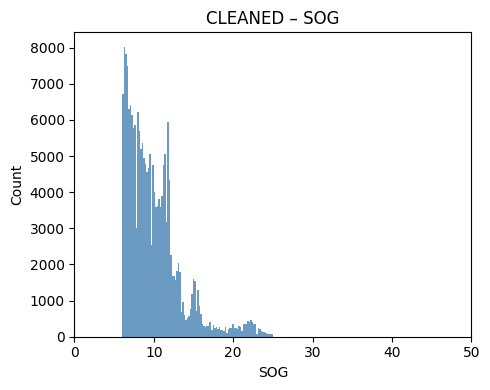

In [40]:
# =========================
# HISTOGRAM – CLEANED DATA
# =========================

# Kiểm tra tồn tại cột
if "SOG" not in df_cleaned.columns:
    raise ValueError("Column 'SOG' not found in df_cleaned")

# Tạo bản chỉ để phân tích
df_cleaned_hist = df_cleaned[
    (df_cleaned["SOG"] >= 6) &
    (df_cleaned["SOG"] <= 25)
]

print("CLEANED shape:", df_cleaned_hist.shape)
print("SOG range:",
      df_cleaned_hist["SOG"].min(),
      "→",
      df_cleaned_hist["SOG"].max())

plot_hist_stage(
    df=df_cleaned_hist,
    cols=["SOG"],
    title_prefix="CLEANED",
    bins=100,
    xlim={"SOG": (0, 50)},
)

In [ ]:
# ### 3 Histogram sau SCALING – Lưu ý tối ưu

# Histogram 3 nên vẽ **trên các cột đã chuẩn hoá sẵn** thay vì gọi lại `scaler.transform`:

# Để tối ưu:

# 1. **Không scale lại**: dùng trực tiếp `df[["X_norm", "Y_norm"]]`.
# 2. **Sample nếu data rất lớn**: dùng tối đa 100k–200k dòng để vẽ, đủ phản ánh phân phối nhưng nhanh.
# 3. **Vẽ kèm mean/std trong tiêu đề** để kiểm tra nhanh `mean ≈ 0`, `std ≈ 1`.
# 4. **Vẽ trên dữ liệu trước window** (ở đây là `df` sau khi có `X_norm`, `Y_norm`), không cần flatten window 92 cột.

X_norm: mean=-0.1688, std=1.0897
Y_norm: mean=-0.1025, std=1.0615


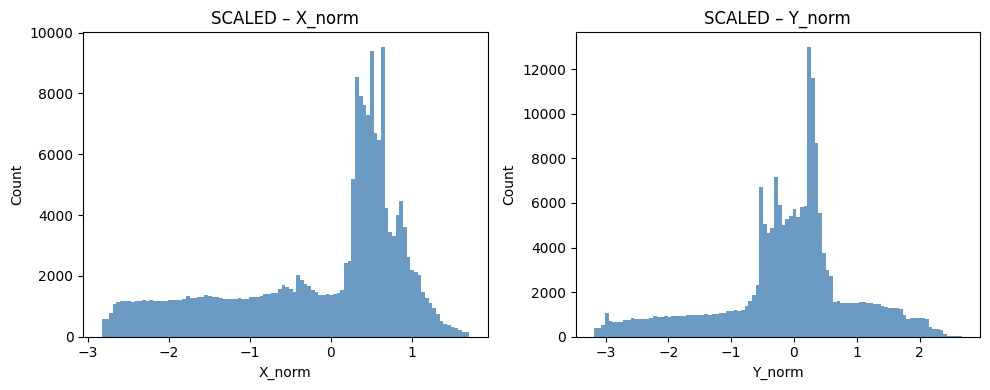

In [ ]:
# 3 Histogram sau SCALING – kiểm tra model readiness

SCALED_COLS = ["X_norm", "Y_norm"]

# Lấy sample để vẽ nhanh nếu cần
if len(df) > 200_000:
    df_scaled_plot = df.sample(n=200_000, random_state=42)
else:
    df_scaled_plot = df

for col in SCALED_COLS:
    if col not in df_scaled_plot.columns:
        print(f"[SCALED] Cột {col} không tồn tại, bỏ qua.")
        continue
    mu = df_scaled_plot[col].mean()
    sigma = df_scaled_plot[col].std()
    print(f"{col}: mean={mu:.4f}, std={sigma:.4f}")

plot_hist_stage(
    df=df_scaled_plot,
    cols=SCALED_COLS,
    title_prefix="SCALED",
    bins=100,
    xlim=None,
    logy=False,
)

# Export Data

In [7]:
import pandas as pd
import pyodbc
import os

# =============================
# CẤU HÌNH
# =============================
databases = {
    "Data_2023": "2023",
    "Data_2024": "2024"
}

tables = {
    "training_bay": "bay",
    "training_offshore": "offshore"
}

chunk_size = 50000
root_folder = "Data_Export_vsc"

# =============================
# EXPORT
# =============================
for db_name, year in databases.items():

    print(f"\n===== Processing {db_name} =====")

    conn = pyodbc.connect(
        "DRIVER={ODBC Driver 18 for SQL Server};"
        "SERVER=localhost,1433;"
        f"DATABASE={db_name};"
        "UID=sa;"
        "PWD=123Strong!;"
        "TrustServerCertificate=yes;"
    )

    for table_name, subfolder in tables.items():

        print(f"Exporting {table_name}...")

        # Tạo folder năm + bay/offshore
        output_path = os.path.join(root_folder, year, subfolder)
        os.makedirs(output_path, exist_ok=True)

        query = f"SELECT * FROM {table_name}"
        i = 0

        for chunk in pd.read_sql(query, conn, chunksize=chunk_size):
            filename = os.path.join(
                output_path,
                f"{table_name}_part{i}.csv"
            )
            chunk.to_csv(filename, index=False)
            print(f"Saved {filename}")
            i += 1

    conn.close()

print("\nALL EXPORT DONE 🚀")


===== Processing Data_2023 =====
Exporting training_bay...


C:\Users\USER\AppData\Local\Temp\ipykernel_5792\1517444921.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql(query, conn, chunksize=chunk_size):


Saved Data_Export_vsc\2023\bay\training_bay_part0.csv
Saved Data_Export_vsc\2023\bay\training_bay_part1.csv
Saved Data_Export_vsc\2023\bay\training_bay_part2.csv
Saved Data_Export_vsc\2023\bay\training_bay_part3.csv
Saved Data_Export_vsc\2023\bay\training_bay_part4.csv
Saved Data_Export_vsc\2023\bay\training_bay_part5.csv
Saved Data_Export_vsc\2023\bay\training_bay_part6.csv
Saved Data_Export_vsc\2023\bay\training_bay_part7.csv
Saved Data_Export_vsc\2023\bay\training_bay_part8.csv
Saved Data_Export_vsc\2023\bay\training_bay_part9.csv
Saved Data_Export_vsc\2023\bay\training_bay_part10.csv
Saved Data_Export_vsc\2023\bay\training_bay_part11.csv
Saved Data_Export_vsc\2023\bay\training_bay_part12.csv
Saved Data_Export_vsc\2023\bay\training_bay_part13.csv
Saved Data_Export_vsc\2023\bay\training_bay_part14.csv
Saved Data_Export_vsc\2023\bay\training_bay_part15.csv
Saved Data_Export_vsc\2023\bay\training_bay_part16.csv
Saved Data_Export_vsc\2023\bay\training_bay_part17.csv
Saved Data_Export_vs